In [1]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 309.74 GB


In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os
from deepgo.utils import Ontology

In [3]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [4]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [5]:
tokenizer.get_vocab_size()


544998

In [6]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [7]:
import csv

defense_ips = []
directory = "/home/toibazd/Defense_InterPros/"
file_list = os.listdir(directory)

for file in file_list:
    print(file)
    file_path = os.path.join(directory, file)
    with open(file_path, 'r', newline='') as infile:
        reader = csv.reader(infile, delimiter = "\t")
        next(reader)
        for row in reader:
            ip = row[0]
            defense_ips.append(ip)

LIT_IP.tsv
CRISPR_IP.tsv
BREX_IP.tsv
DISARM_IP.tsv
AbiH_IP.tsv
Kiwa_IP.tsv


In [102]:
defense_ips

['IPR019504',
 'IPR002729',
 'IPR002764',
 'IPR005510',
 'IPR005537',
 'IPR006482',
 'IPR007522',
 'IPR009260',
 'IPR010144',
 'IPR010146',
 'IPR010147',
 'IPR010148',
 'IPR010149',
 'IPR010152',
 'IPR010153',
 'IPR010154',
 'IPR010155',
 'IPR010156',
 'IPR010157',
 'IPR010160',
 'IPR010163',
 'IPR010165',
 'IPR010171',
 'IPR010172',
 'IPR010173',
 'IPR010179',
 'IPR010180',
 'IPR010184',
 'IPR011742',
 'IPR013337',
 'IPR013343',
 'IPR013381',
 'IPR013382',
 'IPR013389',
 'IPR013395',
 'IPR013396',
 'IPR013397',
 'IPR013398',
 'IPR013399',
 'IPR013403',
 'IPR013407',
 'IPR013408',
 'IPR013409',
 'IPR013410',
 'IPR013411',
 'IPR013412',
 'IPR013413',
 'IPR013414',
 'IPR013415',
 'IPR013418',
 'IPR013419',
 'IPR013421',
 'IPR013443',
 'IPR013444',
 'IPR013487',
 'IPR013488',
 'IPR013489',
 'IPR013490',
 'IPR013492',
 'IPR014055',
 'IPR014082',
 'IPR014174',
 'IPR016581',
 'IPR016620',
 'IPR017545',
 'IPR017546',
 'IPR017547',
 'IPR017548',
 'IPR017574',
 'IPR017575',
 'IPR017576',
 'IPR0

In [104]:
print("Defense IPs number: ", len(defense_ips))

Defense IPs number:  120


In [101]:
from collections import defaultdict
import csv
from tqdm.auto import tqdm
import numpy as np



new_tsv_filename = "/home/toibazd/Family_IPs_with_GO.tsv"
go = Ontology('data/go.obo')
data_dict = defaultdict(list)
ip_to_go = defaultdict(list)


with open(new_tsv_filename, "r") as new_tsvfile:
    reader = csv.reader(new_tsvfile, delimiter="\t")
    next(reader)
    for row in tqdm(reader):
        ip = row[0]  # Assuming the IP is in the first column
        go_terms = row[6]  # Assuming the GO terms are in the second column

        # Add IP and corresponding GO terms to data_dict
        ip_to_go[ip]+=go_terms.split(',')

print(ip_to_go)

with open("/home/toibazd/Prot2IP.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in defense_ips and ip_to_go[ip]:
                for GO in ip_to_go[ip]:
                    data_dict[key].append(GO)


0it [00:00, ?it/s]

defaultdict(<class 'list'>, {'IPR000003': ['GO:0003677', 'GO:0003707', 'GO:0008270', 'GO:0006355', 'GO:0005634'], 'IPR000006': ['GO:0046872'], 'IPR000009': ['GO:0019888', 'GO:0000159'], 'IPR000011': ['GO:0008641', 'GO:0036211'], 'IPR000012': ['GO:0019058', 'GO:0042025'], 'IPR000013': ['GO:0004222', 'GO:0008270', 'GO:0006508', 'GO:0005576'], 'IPR000015': ['GO:0015473', 'GO:0009297', 'GO:0016020'], 'IPR000018': ['GO:0045028', 'GO:0007186', 'GO:0030321', 'GO:0016020'], 'IPR000021': ['GO:0016020'], 'IPR000025': ['GO:0008502', 'GO:0007186', 'GO:0016020'], 'IPR000026': ['GO:0003723', 'GO:0004521'], 'IPR000036': ['GO:0004175', 'GO:0006508', 'GO:0009279'], 'IPR000037': ['GO:0003723'], 'IPR000039': ['GO:0003735', 'GO:0006412', 'GO:0005840'], 'IPR000040': ['GO:0003677', 'GO:0005524', 'GO:0006355', 'GO:0005634'], 'IPR000044': ['GO:0016020'], 'IPR000046': ['GO:0004995', 'GO:0007186', 'GO:0005886', 'GO:0016020'], 'IPR000053': ['GO:0004645', 'GO:0006206'], 'IPR000054': ['GO:0003735', 'GO:0006412', '

0it [00:00, ?it/s]

In [31]:
print(data_dict)

defaultdict(<class 'list'>, {'WP_003439780': ['GO:0004521', 'GO:0043571'], 'WP_011745279': ['GO:0043571', 'GO:0004519', 'GO:0051607'], 'WP_003871087': ['GO:0004521', 'GO:0043571'], 'WP_011681111': ['GO:0016788'], 'WP_013240887': ['GO:0043571'], 'WP_003414279': ['GO:0003676', 'GO:0004519', 'GO:0046872', 'GO:0043571', 'GO:0051607'], 'WP_012515202': ['GO:0004521', 'GO:0043571'], 'WP_009890657': ['GO:0043571'], 'WP_003588545': ['GO:0003676', 'GO:0004519', 'GO:0046872', 'GO:0043571', 'GO:0051607', 'GO:0004520', 'GO:0046872', 'GO:0043571'], 'WP_014613261': ['GO:0004521', 'GO:0043571'], 'WP_013702994': ['GO:0016788'], 'WP_109637282': ['GO:0004519', 'GO:0043571'], 'WP_002946754': ['GO:0004521', 'GO:0043571'], 'WP_025505432': ['GO:0004519', 'GO:0043571'], 'WP_003414276': ['GO:0004521', 'GO:0043571'], 'WP_000350182': ['GO:0004519', 'GO:0043571'], 'WP_032685325': ['GO:0003676', 'GO:0004519', 'GO:0046872', 'GO:0043571', 'GO:0051607'], 'WP_003016518': ['GO:0004521', 'GO:0043571'], 'WP_080542829': [

In [36]:
all_values = [value for values in data_dict.values() for value in values]

# Convert the list into a set to remove duplicates
unique_defense = set(all_values)

print("Number of unique words:", len(unique_defense))

Number of unique words: 9


In [37]:
print(unique_defense)

{'GO:0043571', 'GO:0004520', 'GO:0003676', 'GO:0003723', 'GO:0016788', 'GO:0004521', 'GO:0046872', 'GO:0051607', 'GO:0004519'}


In [38]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
enc.fit(ip_to_go.values())
one_hot_encoded = enc.transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

266


In [39]:
one_hot_encoded.shape

(266, 5349)

In [ ]:
import os
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

directory = '/ibex/user/toibazd/InterPro_annotated_genomes/'
one_hot_encoded_sentences = {}

sentence_length = 40
sentences_per_IP = 100

# Set random seed for reproducibility
random.seed(42)

# Randomly choose 1000 files with seed 42
selected_files = os.listdir(directory)


# Define a function to process a file
def process_file(filename, IP):
    sentences = []

    filepath = os.path.join(directory, filename)

    with open(filepath, 'r') as file:
        content = file.read()
        words = content.strip().split()

        # Check if the key is in the file
        for i in range(19, len(words)-20):
            # Shuffle the indices of the words containing the key
            if IP in data_dict[words[i]]:
                if len(words) - i >= 21:
                    sentence = " ".join(words[i - 19:i + sentence_length - 19])
                    sentences.append(sentence)
    return sentences


# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences[IP] = []
    sentences_count = 0

    # Use ThreadPoolExecutor for concurrent processing
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_file, filename, IP) for filename in selected_files]
        for future in futures:
            sentences = future.result()
            one_hot_encoded_sentences[IP].extend(sentences)
            sentences_count += len(sentences)
            if sentences_count >= sentences_per_IP:
                break

    # Break if the required number of sentences per key is reached


In [ ]:
for key, values in one_hot_encoded_sentences.items():
    print(len(values))

In [ ]:
import json

with open('BERT_sanity_check_defense_DNN_senteces.json', 'w') as f:
    json.dump(one_hot_encoded_sentences, f)

In [43]:
import json
with open('BERT_sanity_check_defense_DNN_senteces.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [44]:
for key, value in one_hot_encoded_sentences.items():
    print(key, end=" ")
    print(len(value))

GO:0044419 101
GO:0006259 100
GO:0006139 100
GO:0034641 100
GO:0050896 101
GO:0043169 102
GO:0140640 100
GO:0003674 100
GO:0043170 100
GO:0044237 100
GO:0046483 100
GO:0006807 100
GO:0006725 100
GO:0004521 100
GO:0006996 100
GO:0009605 101
GO:0016788 111
GO:0009615 101
GO:0004518 110
GO:0051707 101
GO:0009987 100
GO:0006950 101
GO:0043167 102
GO:1901360 100
GO:0004519 110
GO:0140546 101
GO:0003824 111
GO:0044238 100
GO:0003723 100
GO:0071704 100
GO:0090304 100
GO:0003676 100
GO:0043571 100
GO:0004540 100
GO:0051607 101
GO:0140098 100
GO:0043570 100
GO:0043207 101
GO:0005488 100
GO:0098542 101
GO:0006952 101
GO:0016787 111
GO:0046872 102
GO:0051276 100
GO:0008152 100
GO:0071840 100
GO:0097159 100
GO:0009607 101
GO:0016043 100
GO:0036094 102
GO:0004536 100
GO:0008150 100
GO:0140097 100
GO:0004520 100


In [45]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
len(one_hot_encoded_sentences)

54

In [46]:
matching_string = one_hot_encoded_sentences.values()
len(matching_string)

54

In [47]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

5473

In [48]:
count= 0
for string in matching_string:
    words = string.split(" ")
    if not words[19] in data_dict.keys():

        count+=1
    else:
        count+=0
print(count)

0


In [49]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-03-08 10:58:05,807] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [50]:
print(one_hot_encoded[1].shape)

(5349,)


In [51]:
batch_size = 128 # Define your batch size
model.cuda()
embeddings = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 20, :]  # Extract the 20th token's hidden state
    
    for j in range(len(batch_sentences)):
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        labels.append(one_hot_encoded_dict[indicator])

# Ensure order in embeddings matches order in labels

# Now embeddings and labels are stored on the CPU


  0%|          | 0/43 [00:00<?, ?it/s]

In [52]:
labels

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0,

In [53]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    print(neg_counts)
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
print(class_counts)
pos_weights = calculate_pos_weights(class_counts) 

[0 0 0 ... 0 0 0]
[5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 5473, 547

In [54]:
pos_weights[pos_weights == 0] = 1
pos_weights

tensor([5.4730e+08, 5.4730e+08, 5.4730e+08,  ..., 5.4730e+08, 5.4730e+08,
        5.4730e+08])

In [55]:
import random

random.seed(42)
# Zip the lists together
combined = list(zip(embeddings, labels))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list
embeddings, labels = zip(*combined)



In [56]:
model.to("cpu")
torch.cuda.empty_cache()

In [57]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 128
second_hidden = 64
last_hidden = 32
output_dim = 5349
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [58]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels


optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [59]:
import numpy as np

num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        outputs = clf_model(batch_embeddings_tensor)
        loss = criterion(outputs, batch_labels_tensor)
#         print(loss)
        train_loss+=loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")

Epoch 1/20:


Training Batches: 0it [00:00, ?it/s]

0.442215724856549
Epoch 2/20:


Training Batches: 0it [00:00, ?it/s]

0.009501842738679007
Epoch 3/20:


Training Batches: 0it [00:00, ?it/s]

0.002637269209186185
Epoch 4/20:


Training Batches: 0it [00:00, ?it/s]

0.0022243647357129363
Epoch 5/20:


Training Batches: 0it [00:00, ?it/s]

0.0019800171307796056
Epoch 6/20:


Training Batches: 0it [00:00, ?it/s]

0.0018231043775535122
Epoch 7/20:


Training Batches: 0it [00:00, ?it/s]

0.0016767462314253379
Epoch 8/20:


Training Batches: 0it [00:00, ?it/s]

0.0014277709079315865
Epoch 9/20:


Training Batches: 0it [00:00, ?it/s]

0.0014172760688385144
Epoch 10/20:


Training Batches: 0it [00:00, ?it/s]

0.0011826182060282648
Epoch 11/20:


Training Batches: 0it [00:00, ?it/s]

0.0011740647761429247
Epoch 12/20:


Training Batches: 0it [00:00, ?it/s]

0.0011429461799786597
Epoch 13/20:


Training Batches: 0it [00:00, ?it/s]

0.0011956528531618534
Epoch 14/20:


Training Batches: 0it [00:00, ?it/s]

0.0011928140621570397
Epoch 15/20:


Training Batches: 0it [00:00, ?it/s]

0.0011259983103976223
Epoch 16/20:


Training Batches: 0it [00:00, ?it/s]

0.001119588694210007
Epoch 17/20:


Training Batches: 0it [00:00, ?it/s]

0.0011619551227425127
Epoch 18/20:


Training Batches: 0it [00:00, ?it/s]

0.001113430821337997
Epoch 19/20:


Training Batches: 0it [00:00, ?it/s]

0.0011528990012449776
Epoch 20/20:


Training Batches: 0it [00:00, ?it/s]

0.0010690590362977485
Training finished.


In [ ]:
directory = '/ibex/user/toibazd/InterPro_annotated_genomes_for_testing/'
one_hot_encoded_sentences_2 = {}

sentence_length = 40
sentence_per_IP = 50
selected_files = os.listdir(directory)

total_sentences = sum(len(sentences) for sentences in one_hot_encoded_sentences.values())

# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences_2[IP] = []
    sentences_count=0
    
    # Iterate over selected files
    for filename in selected_files:
        filepath = os.path.join(directory, filename)

        with open(filepath, 'r') as file:
            content = file.read()
            words = content.strip().split()

            # Check if the key is in the file
            for i in range(19, len(words)-20):
                # Shuffle the indices of the words containing the key
                if IP in data_dict[words[i]]:
                    if len(words) - i >= 21:
                        sentence = " ".join(words[i - 19:i + sentence_length - 19])
                        one_hot_encoded_sentences_2[IP].append(sentence)
                        sentences_count += 1
                        if sentences_count>=sentence_per_IP:
                            break
        if sentences_count>=sentence_per_IP:
            break
    print(sentences_count)
            


In [ ]:
for key, value in one_hot_encoded_sentences_2.items():
    print(len(value))

In [ ]:
import json

with open('BERT_sanity_check_defense_DNN_senteces_testing.json', 'w') as f:
    json.dump(one_hot_encoded_sentences_2, f)

In [60]:
with open('BERT_sanity_check_defense_DNN_senteces_testing.json', "r") as f:
    test_sentences = json.load(f)

In [61]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

54

In [62]:
matching_string = test_sentences.values()
len(matching_string)

54

In [63]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

2700

In [64]:
from bertviz import model_view

batch_size = 128 # Define your batch size
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]
    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions = True)
    hidden_states = outputs.last_hidden_state
    attentions = outputs.attentions[-1]
    relevant_hidden_states = hidden_states[:, 20, :]  # Extract the 20th token's hidden state
#     for i in range(len(batch_sentences)):
#         if i < 20:
#             att = []
#             extracted_tensor = attentions[i, :, :, :]
#             extracted_tensor = extracted_tensor.unsqueeze(0)
#             print(extracted_tensor.shape)
#             att.append(extracted_tensor)

#             tokens = "[CLS] "+tokenizer.decode(input_ids_list[i])+" [SEP]"
#             tokens = tokens.split(" ")
#             model_view(att, tokens)
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        test_labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/22 [00:00<?, ?it/s]

In [65]:
tokenizer.decode([0,12,12,12,12,
                 ])

'WP_072018053 WP_072018053 WP_072018053 WP_072018053'

In [66]:
model.to("cpu")
torch.cuda.empty_cache()

In [67]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=5349, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [93]:
generator = data_generator(test_embeddings, test_labels, batch_size)
# Iterate over batches
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []
# Initialize lists to store predictions and labels across all batches
# Iterate over batches
count = 0
for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.7).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


Evaluation Batches: 0it [00:00, ?it/s]

In [94]:
len(all_predictions)

22

In [95]:
len(all_labels[0])
    

128

In [96]:
print(all_predictions[0].shape)

(128, 5349)


In [97]:
print(all_labels[0].shape)

(128, 5349)


In [98]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [99]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

0.9999424850652544


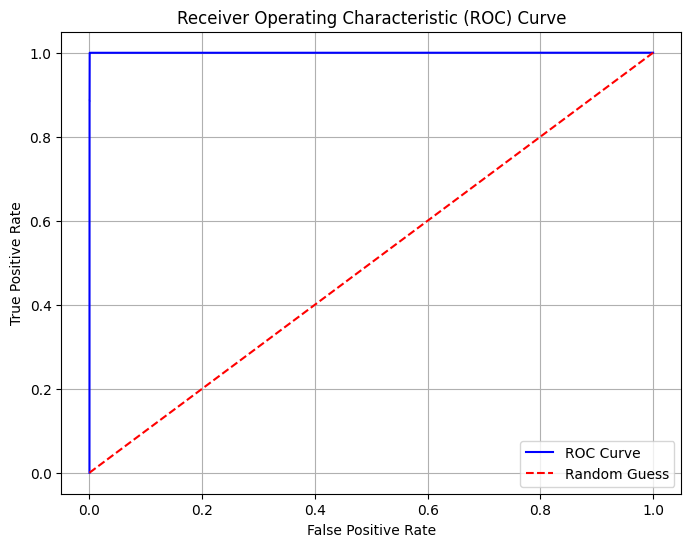

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [87]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
5349


In [88]:
print(cl_report[0])

[[2700    0]
 [   0    0]]


In [89]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [90]:
all_predictions.sum(axis=0)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [91]:
print(report)

              precision    recall  f1-score   support

           0        nan       nan       nan         0
           1        nan       nan       nan         0
           2        nan       nan       nan         0
           3        nan       nan       nan         0
           4        nan       nan       nan         0
           5        nan       nan       nan         0
           6        nan       nan       nan         0
           7        nan       nan       nan         0
           8        nan       nan       nan         0
           9        nan       nan       nan         0
          10        nan       nan       nan         0
          11        nan       nan       nan         0
          12        nan       nan       nan         0
          13        nan       nan       nan         0
          14        nan       nan       nan         0
          15        nan       nan       nan         0
          16        nan       nan       nan         0
          17        nan    

In [ ]:
list(enc.classes_)[15]

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
num_classes = 83
# Compute precision, recall, and thresholds for each class
precision = dict()
recall = dict()
thresholds = dict()
average_precision = dict()

for i in range(num_classes):  # num_classes is the number of classes
    precision[i], recall[i], thresholds[i] = precision_recall_curve(all_labels[:, i], all_predictions[:, i])
    average_precision[i] = average_precision_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(all_labels.ravel(), all_predictions.ravel())
average_precision["micro"] = average_precision_score(all_labels, all_predictions, average="micro")

# Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_predictions[:, i])
    roc_auc[i] = roc_auc_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_predictions.ravel())
roc_auc["micro"] = roc_auc_score(all_labels, all_predictions, average="micro")

# Split classes into groups of 10
class_groups = [list(range(i, min(i + 10, num_classes))) for i in range(0, num_classes, 10)]

# Plot Precision-Recall and ROC curves for each group
for group in class_groups:
    plt.figure(figsize=(12, 6))

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 1)
    plt.step(recall['micro'], precision['micro'], where='post', label='Micro-average Precision-Recall curve (AUPR = {0:0.2f})'
                 ''.format(average_precision["micro"]))
    for i in group:
        plt.step(recall[i], precision[i], where='post', label='Precision-recall curve of class {0} (AUPR = {1:0.2f})'
                 ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (Classes {})'.format(group))
    plt.legend(loc="best")

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr['micro'], tpr['micro'], label='Micro-average ROC curve (AUC = {0:0.2f})'
                 ''.format(roc_auc["micro"]))
    for i in group:
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Classes {})'.format(group))
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


In [ ]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))